In [81]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import os

import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
from nltk.util import ngrams
import string
from sklearn.feature_extraction.text import TfidfVectorizer



from wordcloud import WordCloud
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
articles_path = '/Users/kuba/Desktop/PBL/EDA/Articles/articles_01-01-2024_14h39m35s.csv'
trials_path = '/Users/kuba/Desktop/PBL/EDA/Trials/trials_01-01-2024_14h39m35s.csv'

articles = pd.read_csv(articles_path, index_col=0)
trials = pd.read_csv(trials_path, index_col=0)

# Frequency of Word Analysis
Frequency of words analysis in Relevant/not articles (word cloud)

## Articles

In [7]:
articles.summary = articles.summary.astype(str)

### Stemming

In [79]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Function to preprocess text
def preprocess_stemming(text):
    stop_words = set(stopwords.words('english'))
    text = text.translate(str.maketrans('', '', string.punctuation))
    stemmer = PorterStemmer()
    words = word_tokenize(text.lower())
    return [stemmer.stem(word) for word in words if word not in stop_words and word.isalpha()]

# Splitting the dataset based on the 'relevant' column
relevant_articles = articles[articles['relevant'] == True]['summary']
non_relevant_articles = articles[articles['relevant'] == False]['summary']

# Word frequency count for relevant articles
word_freq_relevant = Counter()
for summary in relevant_articles.dropna():
    word_freq_relevant.update(preprocess_stemming(summary))

# Word frequency count for non-relevant articles
word_freq_non_relevant = Counter()
for summary in non_relevant_articles.dropna():
    word_freq_non_relevant.update(preprocess_stemming(summary))

# Top words in each class
top_words_relevant = word_freq_relevant.most_common(10)
top_words_non_relevant = word_freq_non_relevant.most_common(10)

top_words_relevant, top_words_non_relevant

[nltk_data] Downloading package punkt to /Users/kuba/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kuba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


([('ms', 1527),
  ('cell', 1387),
  ('diseas', 1041),
  ('effect', 937),
  ('studi', 881),
  ('sclerosi', 866),
  ('treatment', 828),
  ('multipl', 814),
  ('patient', 800),
  ('activ', 674)],
 [('patient', 431),
  ('ms', 225),
  ('diseas', 214),
  ('studi', 199),
  ('use', 186),
  ('multipl', 181),
  ('sclerosi', 181),
  ('treatment', 142),
  ('clinic', 141),
  ('vaccin', 135)])

### Lemmatization

In [80]:
nltk.download('wordnet')

# Function to preprocess text
def preprocess_lemma(text):
    stop_words = set(stopwords.words('english'))
    text = text.translate(str.maketrans('', '', string.punctuation))
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text.lower())
    return [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalpha()]

# Splitting the dataset based on the 'relevant' column
relevant_articles = articles[articles['relevant'] == True]['summary']
non_relevant_articles = articles[articles['relevant'] == False]['summary']

# Word frequency count for relevant articles
word_freq_relevant = Counter()
for summary in relevant_articles.dropna():
    word_freq_relevant.update(preprocess_lemma(summary))

# Word frequency count for non-relevant articles
word_freq_non_relevant = Counter()
for summary in non_relevant_articles.dropna():
    word_freq_non_relevant.update(preprocess_lemma(summary))

# Top words in each class
top_words_relevant = word_freq_relevant.most_common(10)
top_words_non_relevant = word_freq_non_relevant.most_common(10)

top_words_relevant, top_words_non_relevant

[nltk_data] Downloading package wordnet to /Users/kuba/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


([('m', 1527),
  ('cell', 1387),
  ('disease', 1038),
  ('sclerosis', 866),
  ('study', 847),
  ('treatment', 828),
  ('multiple', 814),
  ('patient', 800),
  ('effect', 743),
  ('mouse', 686)],
 [('patient', 431),
  ('m', 225),
  ('disease', 214),
  ('study', 193),
  ('multiple', 181),
  ('sclerosis', 181),
  ('treatment', 142),
  ('cell', 135),
  ('doi', 131),
  ('clinical', 118)])

### Relative Frequencies

In [69]:
def calculate_relative_frequencies(word_counts, total_words):
    return {word: (count / total_words) for word, count in word_counts.items()}

def find_characteristic_keywords(freq_class_1, freq_class_2, threshold=0.01):
    characteristic_keywords = {}
    for word in freq_class_1.keys():
        relative_freq_1 = freq_class_1.get(word, 0)
        relative_freq_2 = freq_class_2.get(word, 0)
        if relative_freq_1 - relative_freq_2 > threshold:
            characteristic_keywords[word] = relative_freq_1
    return characteristic_keywords

# Calculate total words in each class
total_words_relevant = sum(word_freq_relevant.values())
total_words_non_relevant = sum(word_freq_non_relevant.values())

# Calculate relative frequencies
relative_freq_relevant = calculate_relative_frequencies(word_freq_relevant, total_words_relevant)
relative_freq_non_relevant = calculate_relative_frequencies(word_freq_non_relevant, total_words_non_relevant)

In [70]:
# Function to calculate relative frequency difference and get top characteristic words
def get_top_characteristic_words(freq_class_1, freq_class_2, top_n=10):
    diff_freq = {word: freq_class_1.get(word, 0) - freq_class_2.get(word, 0) for word in freq_class_1.keys()}
    # Sort by difference in frequency
    sorted_diff = sorted(diff_freq.items(), key=lambda x: x[1], reverse=True)
    return sorted_diff[:top_n]

# Get the top characteristic words for each class
top_characteristic_words_relevant = get_top_characteristic_words(relative_freq_relevant, relative_freq_non_relevant)
top_characteristic_words_non_relevant = get_top_characteristic_words(relative_freq_non_relevant, relative_freq_relevant)

# Print top characteristic words
print("Top Characteristic Words for Relevant Articles:", top_characteristic_words_relevant)
print("Top Characteristic Words for Non-Relevant Articles:", top_characteristic_words_non_relevant)


Top Characteristic Words for Relevant Articles: [('cell', 0.00820638727262464), ('eae', 0.006317279904879812), ('mouse', 0.005544951701416016), ('m', 0.005138537546424923), ('effect', 0.004615707019701762), ('myelin', 0.0038831866675249783), ('demyelination', 0.003341592213452188), ('oligodendrocyte', 0.0030695549604164646), ('cns', 0.0029615917236657345), ('therapeutic', 0.0029308467000409054)]
Top Characteristic Words for Non-Relevant Articles: [('patient', 0.009485843240797058), ('pwms', 0.002976106855145707), ('nan', 0.002828116658800784), ('age', 0.0026554720146740834), ('infection', 0.002617642489117113), ('vaccination', 0.0023917958076210264), ('case', 0.0023311536142556714), ('vaccine', 0.0021705535760584253), ('people', 0.0017920392121815376), ('care', 0.0017360745048520614)]


### TF-IDF

In [107]:
# Function to extract top features from TF-IDF for each class
def get_top_tfidf_features(matrix, feature_names, class_index, top_n=10):
    feature_index = matrix[class_index, :].nonzero()[1]
    tfidf_scores = zip(feature_index, [matrix[class_index, x] for x in feature_index])
    sorted_items = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)
    top_features = [(feature_names[idx], score) for idx, score in sorted_items[:top_n]]
    return top_features

#### All articles, cumulative

[('setting', 0.41702882811414954), ('infection', 0.3127716210856122), ('patient', 0.3127716210856122), ('case', 0.3127716210856122), ('neurological', 0.3127716210856122), ('myelitis', 0.20851441405707477), ('associated', 0.10425720702853739), ('checked', 0.10425720702853739), ('antibody', 0.10425720702853739), ('trigger', 0.10425720702853739)]


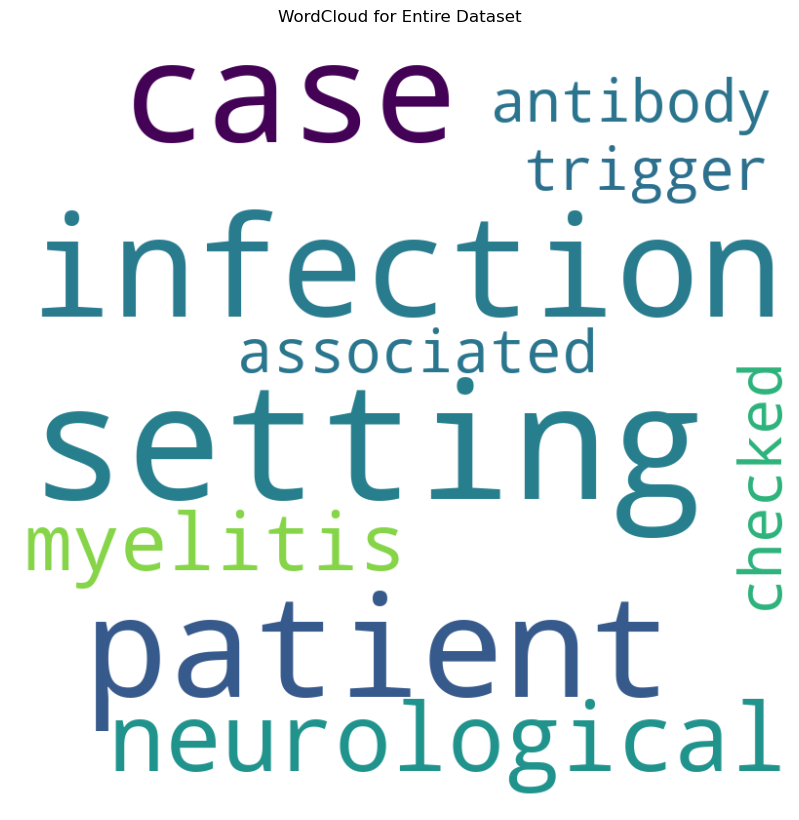

In [72]:
# Process all texts
all_processed_texts = articles[articles.summary.notna()].summary.apply(preprocess_lemma)

# Creating a corpus with all texts
corpus_all_texts = ' '.join(all_processed_texts[0])

# Initialize the TF-IDF Vectorizer, excluding stop words
tfidf_vectorizer_all = TfidfVectorizer(stop_words='english')

# Apply TF-IDF to the entire dataset
tfidf_matrix_all = tfidf_vectorizer_all.fit_transform([corpus_all_texts])

# Extract feature names
feature_names_all = tfidf_vectorizer_all.get_feature_names_out()

# Extract top features from TF-IDF for the entire dataset
top_features_all = get_top_tfidf_features(tfidf_matrix_all, feature_names_all, 0)

# Creating a word cloud for the entire dataset
wordcloud_all = WordCloud(width=800, height=800, background_color='white')
wordcloud_all.generate_from_frequencies(dict(top_features_all))

print(top_features_all)

# Plotting the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud_all, interpolation="bilinear")
plt.title("WordCloud for Entire Dataset")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

#### Relevant/Not Relevant

In [73]:
# Apply preprocessing to each text in the relevant and non-relevant articles
processed_relevant = relevant_articles.apply(preprocess_lemma).to_list()
processed_non_relevant = non_relevant_articles.apply(preprocess_lemma).to_list()

# Concatenate all preprocessed texts in each class
concatenated_relevant = ' '.join(processed_relevant[0])
concatenated_non_relevant = ' '.join(processed_non_relevant[0])

# Creating a corpus with the concatenated texts
corpus = [concatenated_relevant, concatenated_non_relevant]

# Initialize the TF-IDF Vectorizer, excluding stop words
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Apply TF-IDF to the corpus
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Extract feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get top TF-IDF features for each class
top_features_relevant = get_top_tfidf_features(tfidf_matrix, feature_names, 0)
top_features_non_relevant = get_top_tfidf_features(tfidf_matrix, feature_names, 1)

top_features_relevant, top_features_non_relevant

([('neuritis', 0.3532691218038405),
  ('optic', 0.3532691218038405),
  ('group', 0.30280210440329186),
  ('binocular', 0.30280210440329186),
  ('distance', 0.2523350870027432),
  ('near', 0.2523350870027432),
  ('showed', 0.20186806960219458),
  ('control', 0.20186806960219458),
  ('vision', 0.20186806960219458),
  ('vergence', 0.15140105220164593)],
 [('setting', 0.45675208010745194),
  ('infection', 0.34256406008058893),
  ('patient', 0.2437371501464733),
  ('neurological', 0.2437371501464733),
  ('case', 0.2437371501464733),
  ('myelitis', 0.22837604005372597),
  ('associated', 0.11418802002686299),
  ('checked', 0.11418802002686299),
  ('antibody', 0.11418802002686299),
  ('trigger', 0.11418802002686299)])

### WordClouds

/var/folders/s4/67mds2cx77j5lthp_x3dx4dw0000gn/T/ipykernel_28825/2075061045.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0)


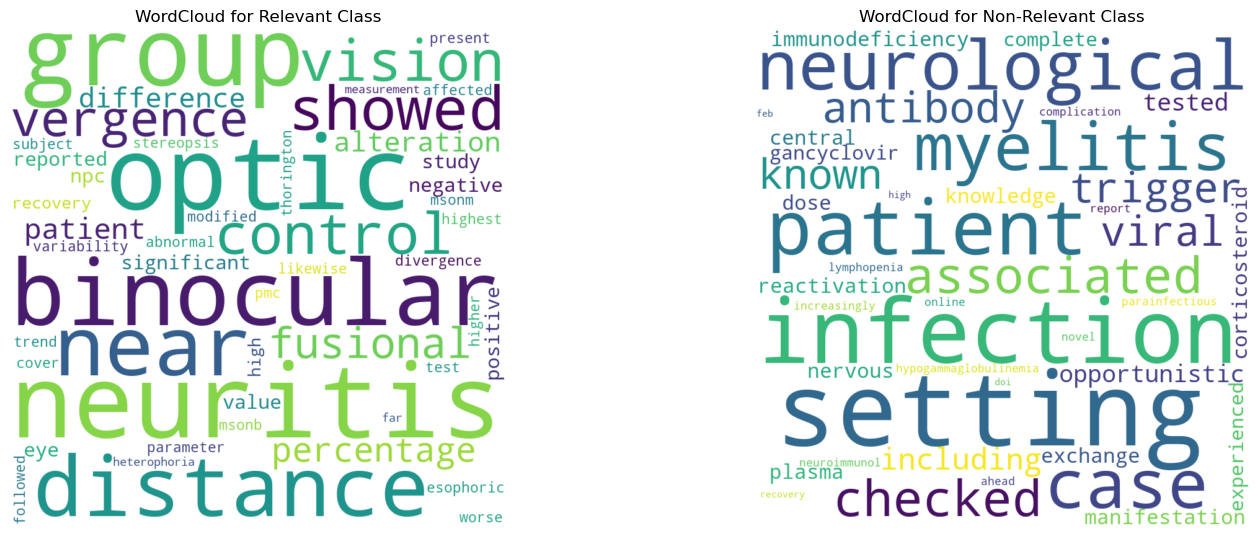

In [74]:
# Recompute top TF-IDF features for each class
top_features_relevant = get_top_tfidf_features(tfidf_matrix, feature_names, 0, 50)
top_features_non_relevant = get_top_tfidf_features(tfidf_matrix, feature_names, 1, 50)


# Function to create a wordcloud based on TF-IDF scores
def create_wordclouds(tfidf_scores_classes, titles):
    # Setting up subplots with added spacing
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'wspace': 0.5})

    for i, (tfidf_scores, title) in enumerate(zip(tfidf_scores_classes, titles)):
        wordcloud = WordCloud(width=800, height=800, background_color='white')
        # Generating the wordcloud with frequencies
        wordcloud.generate_from_frequencies(dict(tfidf_scores))
        # Plotting the wordcloud in subplot
        axes[i].imshow(wordcloud, interpolation="bilinear")
        axes[i].set_title(title)
        axes[i].axis("off")

    plt.tight_layout(pad=0)
    plt.show()

# Creating word clouds for both classes in subplots
create_wordclouds([top_features_relevant, top_features_non_relevant], 
                  ["WordCloud for Relevant Class", "WordCloud for Non-Relevant Class"])

### Differential TF-IDF Analysis
a.k.a Class-Specific Keyword Analysis 

In [75]:

# Function to calculate mean TF-IDF score for each word in a class
def mean_tfidf_scores(matrix, feature_names):
    mean_scores = np.array(matrix.mean(axis=0)).flatten()
    return dict(zip(feature_names, mean_scores))

# Separate TF-IDF calculation for each class
tfidf_matrix_relevant = tfidf_vectorizer.fit_transform(processed_relevant[0])
feature_names_relevant = tfidf_vectorizer.get_feature_names_out()
mean_scores_relevant = mean_tfidf_scores(tfidf_matrix_relevant, feature_names_relevant)

tfidf_matrix_non_relevant = tfidf_vectorizer.fit_transform(processed_non_relevant[0])
feature_names_non_relevant = tfidf_vectorizer.get_feature_names_out()
mean_scores_non_relevant = mean_tfidf_scores(tfidf_matrix_non_relevant, feature_names_non_relevant)

# Function to find top N differential words
def find_top_differential_words(scores_class1, scores_class2, top_n=10):
    differential_scores = {word: scores_class1.get(word, 0) - scores_class2.get(word, 0) 
                           for word in scores_class1.keys()}
    sorted_differential = sorted(differential_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_differential[:top_n]

# Find top 10 words with high TF-IDF in one class but low in the other
top_differential_words_relevant = find_top_differential_words(mean_scores_relevant, mean_scores_non_relevant)
top_differential_words_non_relevant = find_top_differential_words(mean_scores_non_relevant, mean_scores_relevant)

print("Top Differential Words for Relevant Class:", top_differential_words_relevant)
print("Top Differential Words for Non-Relevant Class:", top_differential_words_non_relevant)




Top Differential Words for Relevant Class: [('neuritis', 0.0457516339869281), ('optic', 0.0457516339869281), ('binocular', 0.0392156862745098), ('group', 0.0392156862745098), ('distance', 0.032679738562091505), ('near', 0.032679738562091505), ('control', 0.026143790849673203), ('showed', 0.026143790849673203), ('vision', 0.026143790849673203), ('fusional', 0.0196078431372549)]
Top Differential Words for Non-Relevant Class: [('setting', 0.06666666666666667), ('infection', 0.05), ('case', 0.043464052287581705), ('neurological', 0.043464052287581705), ('myelitis', 0.03333333333333333), ('patient', 0.0303921568627451), ('ahead', 0.016666666666666666), ('antibody', 0.016666666666666666), ('associated', 0.016666666666666666), ('central', 0.016666666666666666)]


In [66]:
articles.head()

,article_id,title,summary,link,published_date,discovery_date,source,publisher,container_title,authors,relevant,ml_prediction_gnb,ml_prediction_lr,doi,access,takeaways,categories
0,1,"COVID-19, HHV6 and MOG antibody: A perfect storm",J Neuroimmunol. 2021 Feb 12;353:577521. doi: 1...,https://pubmed.ncbi.nlm.nih.gov/33607505/?fc=2...,2021-04-14,2021-02-23,8.0,Elsevier BV,Journal of Neuroimmunology,"Ali Fadhil, Ankita Prasad, Anthony Zampino, Fa...",False,False,False,10.1016/j.jneuroim.2021.577521,open,First case of HHV6 reactivation in central ne...,NaN
1,2,Is Migraine Associated to Brain Anatomical Alt...,Brain Topogr. 2021 Feb 19. doi: 10.1007/s10548...,https://pubmed.ncbi.nlm.nih.gov/33606142/?fc=2...,2021-01-05,2021-02-23,8.0,Springer Science and Business Media LLC,Brain Topography,"Anne Caclin, Aurélie Bidet-Caulet, David Meuni...",False,False,False,10.1007/s10548-021-00824-6,open,Growing number of studies investigate brain a...,NaN
2,3,Patient Satisfaction With the Quality of Couns...,J Neurosci Nurs. 2021 Feb 17. doi: 10.1097/JNN...,https://pubmed.ncbi.nlm.nih.gov/33605649/?fc=2...,2021-03-31,2021-02-23,8.0,Ovid Technologies (Wolters Kluwer Health),Journal of Neuroscience Nursing,"Daniela Händler-Schuster, Diana Zanolari, Gabr...",False,False,False,10.1097/JNN.0000000000000578,restricted,The challenges in dealing with multiple scler...,NaN
3,4,Rare Case of Spinal Neurosarcoidosis with Conc...,Case Rep Neurol Med. 2021 Jan 28;2021:5952724....,https://pubmed.ncbi.nlm.nih.gov/33604089/?fc=2...,2021-01-28,2021-02-23,8.0,Hindawi Limited,Case Reports in Neurological Medicine,"Achraf Makki, Maria Khoueiry, Nesreen Jaafar, ...",NaN,False,False,10.1155/2021/5952724,open,Spinal neurosarcoidosis is a rare disease tha...,NaN
4,5,Evaluation of Urinary Tract Infection followin...,Can J Infect Dis Med Microbiol. 2021 Jan 31;20...,https://pubmed.ncbi.nlm.nih.gov/33603936/?fc=2...,2021-01-31,2021-02-23,8.0,Hindawi Limited,Canadian Journal of Infectious Diseases and Me...,"Aliyeh Bazi, Monireh Ghazaeian, Narjes Hendoie...",False,False,False,10.1155/2021/6616763,open,Double-blind randomized clinical trial was co...,NaN


### TF-IDF N-Grams Analysis

In [82]:
# Function to generate n-grams from a list of texts
def generate_ngrams_from_text_list(text_list, n):
    ngrams_list = []
    for text in text_list:
        processed_words = preprocess_lemma(text)
        ngrams_list.extend(list(ngrams(processed_words, n)))
    return ngrams_list

In [86]:
bigrams_relevant = generate_ngrams_from_text_list(relevant_articles, 2)
trigrams_relevant = generate_ngrams_from_text_list(relevant_articles, 3)

# Generate bi-grams and tri-grams for non-relevant class
bigrams_non_relevant = generate_ngrams_from_text_list(non_relevant_articles, 2)
trigrams_non_relevant = generate_ngrams_from_text_list(non_relevant_articles, 3)

#### Basic N-Gram Frequency (Counter)

In [89]:
# Function to get top n-grams from a list of n-grams
def get_top_ngrams(ngrams_list, top_n=10):
    ngrams_counter = Counter(ngrams_list)
    return ngrams_counter.most_common(top_n)

# Get top 10 bi-grams and tri-grams for the relevant class
top_10_bigrams_relevant = get_top_ngrams(bigrams_relevant)
top_10_trigrams_relevant = get_top_ngrams(trigrams_relevant)

# Get top 10 bi-grams and tri-grams for the non-relevant class
top_10_bigrams_non_relevant = get_top_ngrams(bigrams_non_relevant)
top_10_trigrams_non_relevant = get_top_ngrams(trigrams_non_relevant)

# Combine all bi-grams and tri-grams for the whole dataset
all_bigrams = bigrams_relevant + bigrams_non_relevant
all_trigrams = trigrams_relevant + trigrams_non_relevant

# Get top 10 bi-grams and tri-grams for the whole dataset
top_10_bigrams_all = get_top_ngrams(all_bigrams)
top_10_trigrams_all = get_top_ngrams(all_trigrams)

In [90]:
# Displaying the top 10 bi-grams and tri-grams with annotations for each category

print("Top 10 Bi-grams for Relevant Class:")
print(top_10_bigrams_relevant)

print("\nTop 10 Tri-grams for Relevant Class:")
print(top_10_trigrams_relevant)

print("\nTop 10 Bi-grams for Non-Relevant Class:")
print(top_10_bigrams_non_relevant)

print("\nTop 10 Tri-grams for Non-Relevant Class:")
print(top_10_trigrams_non_relevant)

print("\nTop 10 Bi-grams for Whole Dataset:")
print(top_10_bigrams_all)

print("\nTop 10 Tri-grams for Whole Dataset:")
print(top_10_trigrams_all)



Top 10 Bi-grams for Relevant Class:
[(('multiple', 'sclerosis'), 725), (('sclerosis', 'm'), 439), (('doi', 'online'), 326), (('online', 'ahead'), 326), (('nervous', 'system'), 263), (('central', 'nervous'), 249), (('spinal', 'cord'), 231), (('experimental', 'autoimmune'), 202), (('autoimmune', 'encephalomyelitis'), 194), (('eae', 'mouse'), 171)]

Top 10 Tri-grams for Relevant Class:
[(('multiple', 'sclerosis', 'm'), 340), (('doi', 'online', 'ahead'), 326), (('central', 'nervous', 'system'), 244), (('experimental', 'autoimmune', 'encephalomyelitis'), 190), (('autoimmune', 'encephalomyelitis', 'eae'), 149), (('nervous', 'system', 'cns'), 127), (('disease', 'central', 'nervous'), 62), (('online', 'ahead', 'printabstractmultiple'), 60), (('ahead', 'printabstractmultiple', 'sclerosis'), 60), (('disease', 'multiple', 'sclerosis'), 57)]

Top 10 Bi-grams for Non-Relevant Class:
[(('multiple', 'sclerosis'), 145), (('doi', 'online'), 72), (('online', 'ahead'), 72), (('sclerosis', 'm'), 41), (('m

#### TF-IDF analysis of n-grams from the whole dataset.

In [95]:
# Convert the list of n-grams into a format suitable for TF-IDF vectorization (string format)
bi_grams_joined = [" ".join(bigram) for bigram in all_bigrams]
tri_grams_joined = [" ".join(trigram) for trigram in all_trigrams]

# Function to calculate top TF-IDF features
def calculate_top_tfidf_features(ngrams_list, top_n=10, n_gram_range=(1,1)):
    # Initialize the TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(ngram_range=n_gram_range, stopwords='english')

    # Apply TF-IDF to the n-grams
    tfidf_matrix = tfidf_vectorizer.fit_transform(ngrams_list)

    # Extract feature names and scores
    feature_names = tfidf_vectorizer.get_feature_names_out()
    scores = np.array(tfidf_matrix.sum(axis=0)).flatten()
    sorted_scores = sorted(zip(feature_names, scores), key=lambda x: x[1], reverse=True)

    # Select top n features
    return sorted_scores[:top_n]

# Calculate top 10 TF-IDF features for bi-grams and tri-grams
top_10_tfidf_bigrams = calculate_top_tfidf_features(bi_grams_joined, n_gram_range=(2,2))
top_10_tfidf_trigrams = calculate_top_tfidf_features(tri_grams_joined, n_gram_range=(3,3))

# Print the top 10 TF-IDF features for bi-grams and tri-grams
print("Top 10 TF-IDF Features for Bi-grams:", top_10_tfidf_bigrams)
print("Top 10 TF-IDF Features for Tri-grams:", top_10_tfidf_trigrams)

Top 10 TF-IDF Features for Bi-grams: [('multiple sclerosis', 870.0), ('doi online', 398.0), ('online ahead', 398.0), ('nervous system', 277.0), ('central nervous', 260.0), ('spinal cord', 240.0), ('experimental autoimmune', 203.0), ('autoimmune encephalomyelitis', 195.0), ('eae mouse', 172.0), ('encephalomyelitis eae', 152.0)]
Top 10 TF-IDF Features for Tri-grams: [('doi online ahead', 398.0), ('central nervous system', 255.0), ('experimental autoimmune encephalomyelitis', 190.0), ('autoimmune encephalomyelitis eae', 150.0), ('nervous system cns', 130.0), ('disease multiple sclerosis', 65.0), ('disease central nervous', 64.0), ('ahead printabstractmultiple sclerosis', 62.0), ('online ahead printabstractbackground', 62.0), ('online ahead printabstractmultiple', 62.0)]


#### TF-IDF analysis of n-grams, within class

In [106]:
# Initialize the TF-IDF Vectorizer for bi-grams and tri-grams, excluding stop words
tfidf_vectorizer_bigrams = TfidfVectorizer(stop_words='english', ngram_range=(2, 2))
tfidf_vectorizer_trigrams = TfidfVectorizer(stop_words='english', ngram_range=(3, 3))

# Concatenate all preprocessed texts in each class and for the entire dataset
concatenated_relevant = ' '.join(processed_relevant[0])
concatenated_non_relevant = ' '.join(processed_non_relevant[0])
concatenated_all = ' '.join(processed_relevant[0] + processed_non_relevant[0])

# Apply TF-IDF to the concatenated texts for each class and the entire dataset
tfidf_matrix_relevant_bigrams = tfidf_vectorizer_bigrams.fit_transform([concatenated_relevant])
tfidf_matrix_non_relevant_bigrams = tfidf_vectorizer_bigrams.fit_transform([concatenated_non_relevant])
tfidf_matrix_all_bigrams = tfidf_vectorizer_bigrams.fit_transform([concatenated_all])

tfidf_matrix_relevant_trigrams = tfidf_vectorizer_trigrams.fit_transform([concatenated_relevant])
tfidf_matrix_non_relevant_trigrams = tfidf_vectorizer_trigrams.fit_transform([concatenated_non_relevant])
tfidf_matrix_all_trigrams = tfidf_vectorizer_trigrams.fit_transform([concatenated_all])

# Extract feature names for bi-grams and tri-grams
feature_names_bigrams = tfidf_vectorizer_bigrams.get_feature_names_out()
feature_names_trigrams = tfidf_vectorizer_trigrams.get_feature_names_out()

# Get top TF-IDF features for each class and for the entire dataset
top_features_relevant_bigrams = get_top_tfidf_features(tfidf_matrix_relevant_bigrams, feature_names_bigrams, 0)
top_features_non_relevant_bigrams = get_top_tfidf_features(tfidf_matrix_non_relevant_bigrams, feature_names_bigrams, 0)
top_features_all_bigrams = get_top_tfidf_features(tfidf_matrix_all_bigrams, feature_names_bigrams, 0)

top_features_relevant_trigrams = get_top_tfidf_features(tfidf_matrix_relevant_trigrams, feature_names_trigrams, 0)
top_features_non_relevant_trigrams = get_top_tfidf_features(tfidf_matrix_non_relevant_trigrams, feature_names_trigrams, 0)
top_features_all_trigrams = get_top_tfidf_features(tfidf_matrix_all_trigrams, feature_names_trigrams, 0)

# Print the top TF-IDF features for bi-grams and tri-grams
print("Top TF-IDF Features for Bi-grams in Relevant Class:", top_features_relevant_bigrams)
print("Top TF-IDF Features for Bi-grams in Non-Relevant Class:", top_features_non_relevant_bigrams)
print("Top TF-IDF Features for Bi-grams in Entire Dataset:", top_features_all_bigrams)
print("Top TF-IDF Features for Tri-grams in Relevant Class:", top_features_relevant_trigrams)
print("Top TF-IDF Features for Tri-grams in Non-Relevant Class:", top_features_non_relevant_trigrams)
print("Top TF-IDF Features for Tri-grams in Entire Dataset:", top_features_all_trigrams)


Top TF-IDF Features for Bi-grams in Relevant Class: [('infection including', 0.46770717334674267), ('group negative', 0.2672612419124244), ('binocular optic', 0.2672612419124244), ('case study', 0.2004459314343183), ('doi online', 0.2004459314343183), ('clin optom', 0.1336306209562122), ('neuritis optic', 0.1336306209562122), ('neuritis control', 0.1336306209562122), ('high percentage', 0.1336306209562122), ('group patient', 0.1336306209562122)]
Top TF-IDF Features for Bi-grams in Non-Relevant Class: [('ahead neurological', 0.26967994498529685), ('doi online', 0.13483997249264842), ('alteration binocular', 0.13483997249264842), ('affected parameter', 0.13483997249264842), ('followed msonm', 0.13483997249264842), ('control group', 0.13483997249264842), ('considering high', 0.13483997249264842), ('fusional vergence', 0.13483997249264842), ('checked patient', 0.13483997249264842), ('complication increasingly', 0.13483997249264842)]
Top TF-IDF Features for Bi-grams in Entire Dataset: [('op

In [110]:
# Concatenate all preprocessed texts in each class
concatenated_relevant = ' '.join(processed_relevant[0])
concatenated_non_relevant = ' '.join(processed_non_relevant[0])

# Creating a corpus with the concatenated texts
corpus = [concatenated_relevant, concatenated_non_relevant]

# Creating a corpus with concatenated bi-grams

# TF-IDF Vectorization for bi-grams
tfidf_vectorizer_bigrams = TfidfVectorizer(stop_words='english', ngram_range=(2, 2))
tfidf_matrix_bigrams = tfidf_vectorizer_bigrams.fit_transform(corpus)

# Extract feature names for bi-grams
feature_names_bigrams = tfidf_vectorizer_bigrams.get_feature_names_out()

# Get top TF-IDF features for each class in bi-grams
top_features_bi_grams_relevant = get_top_tfidf_features(tfidf_matrix_bigrams, feature_names_bigrams, 0)
top_features_bi_grams_non_relevant = get_top_tfidf_features(tfidf_matrix_bigrams, feature_names_bigrams, 1)

In [112]:
top_features_bi_grams_relevant, top_features_bi_grams_non_relevant

([('optic neuritis', 0.4682235030761639),
  ('near distance', 0.26755628747209365),
  ('binocular vision', 0.26755628747209365),
  ('control group', 0.20066721560407022),
  ('fusional vergence', 0.20066721560407022),
  ('difference control', 0.13377814373604682),
  ('significant difference', 0.13377814373604682),
  ('showed significant', 0.13377814373604682),
  ('neuritis eye', 0.13377814373604682),
  ('negative fusional', 0.13377814373604682)],
 [('case myelitis', 0.27089866684169056),
  ('patient associated', 0.13544933342084528),
  ('checked patient', 0.13544933342084528),
  ('antibody checked', 0.13544933342084528),
  ('trigger antibody', 0.13544933342084528),
  ('known trigger', 0.13544933342084528),
  ('infection known', 0.13544933342084528),
  ('viral infection', 0.13544933342084528),
  ('including viral', 0.13544933342084528),
  ('infection including', 0.13544933342084528)])

In [113]:
# TF-IDF Vectorization for bi-grams
tfidf_vectorizer_trigrams = TfidfVectorizer(stop_words='english', ngram_range=(3, 3))
tfidf_matrix_trigrams = tfidf_vectorizer_trigrams.fit_transform(corpus)

# Extract feature names for bi-grams
feature_names_trigrams = tfidf_vectorizer_trigrams.get_feature_names_out()

# Get top TF-IDF features for each class in bi-grams
top_features_trigrams_relevant = get_top_tfidf_features(tfidf_matrix_trigrams, feature_names_trigrams, 0)
top_features_trigrams_non_relevant = get_top_tfidf_features(tfidf_matrix_trigrams, feature_names_trigrams, 1)

In [114]:
top_features_trigrams_relevant, top_features_trigrams_non_relevant

([('difference control group', 0.16724840200141838),
  ('significant difference control', 0.16724840200141838),
  ('showed significant difference', 0.16724840200141838),
  ('optic neuritis eye', 0.16724840200141838),
  ('negative fusional vergence', 0.16724840200141838),
  ('worse binocular pmc', 0.08362420100070919),
  ('showed worse binocular', 0.08362420100070919),
  ('neuritis showed worse', 0.08362420100070919),
  ('optic neuritis showed', 0.08362420100070919),
  ('patient optic neuritis', 0.08362420100070919)],
 [('checked patient associated', 0.13867504905630723),
  ('antibody checked patient', 0.13867504905630723),
  ('trigger antibody checked', 0.13867504905630723),
  ('known trigger antibody', 0.13867504905630723),
  ('infection known trigger', 0.13867504905630723),
  ('viral infection known', 0.13867504905630723),
  ('including viral infection', 0.13867504905630723),
  ('infection including viral', 0.13867504905630723),
  ('opportunistic infection including', 0.1386750490563

#### Differentiental TF-IDF for bi-grams and tri-grams WIP